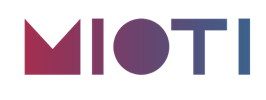
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Computer Vision</center>
<center style="color:#aaa; margin-top:10px;">Prof. Diego García Morate<br>diegogm@faculty.mioti.es</center>


# Challenge S5: Buscando al asesino

## Objetivos

<pre>
05:13 (AM): Un sonido de cristal roto interrumpe el silencio en las oficinas del Banco de España. Alguien ha irrumpido en la cámara acorazada y en el camino ha dejado un par de vigilantes muertos. Suena la alarma.

06:17 (AM): Se persona la Guardia Civil en la cámara, han desaparecido todas las reservas de Oro. Sólo se ha encontrado un móvil en la escena del crimen con 2 fotografías en el carrete. Los agentes revisan las fotografías y no ven más que un par de imágenes de un escritorio...
</pre>

Como estudiantes de visión por computador... ¿podemos ayudar a resolver el misterio? ¿podemos descubrir quien es el asesino?

## Configuración del entorno

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters, color
from skimage.color import rgb2gray
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, FundamentalMatrixTransform
from skimage.transform import resize
from skimage.transform import warp

from ipywidgets import interactive, IntSlider, FloatSlider, VBox, HBox
from IPython.core.display import display, HTML

import operator
import math
import warnings
warnings.filterwarnings("ignore")

from utils import dibujar_corners, dibujar_img, dibujar_imgs, dibujar_puntos, mostrar_frames
from utils import blend_rgb
from utils import extraer_ventana, iterador_ventanas

## ~~Dataset~~ Las pruebas del delito

Dispones en la carpeta `imgs` las fotos del delito:

In [2]:
dataset_rgb = io.ImageCollection('imgs/*.jpg')
print("Cargadas {} instancias.".format(len(dataset_rgb)))

Cargadas 2 instancias.


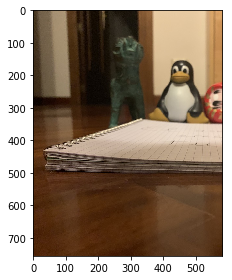

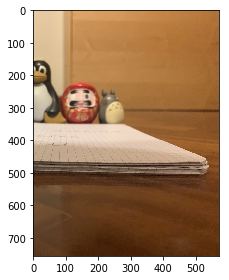

In [3]:
mostrar_frames(dataset_rgb)

## Pegado de las imágenes

¿Crees que con lo que hemos aprendido de pegado de imágenes podemos generar una única imagen con las que tenemos?

In [4]:
def pega_imagenes(img_a, img_b, debug=False, transform=AffineTransform):
    img_a_gris = rgb2gray(img_a)
    img_b_gris = rgb2gray(img_b)

    descriptor_extractor = ORB(n_keypoints=800, fast_threshold=0.05)

    descriptor_extractor.detect_and_extract(img_a_gris)
    keypoints_a = descriptor_extractor.keypoints
    descriptors_a = descriptor_extractor.descriptors
    print("Extraidos {} keypoints de img_a...".format(len(keypoints_a)))

    descriptor_extractor.detect_and_extract(img_b_gris)
    keypoints_b = descriptor_extractor.keypoints
    descriptors_b = descriptor_extractor.descriptors
    print("Extraidos {} keypoints de img_b...".format(len(keypoints_b)))

    # cross check chequea que sean matches juntos
    matches = match_descriptors(descriptors_a, descriptors_b, cross_check=True)
    print("Localizados {} matches...".format(len(matches)))

    if debug:
        plt.figure(figsize=(20,10))
        plot_matches(plt, img_a, img_b, keypoints_a, keypoints_b, matches, only_matches=True)

    # Invertimos las coordenadas de (y, x) a (x, y)
    src = keypoints_a[matches[:, 0]][:, ::-1]
    dst = keypoints_b[matches[:, 1]][:, ::-1]

    model, inliers = ransac(
        (src, dst),
        transform, 
        min_samples=8,
        residual_threshold=1, 
        max_trials=5000
    )

    if debug:
        plt.figure(figsize=(20,10))
        plot_matches(plt, img_a, img_b, keypoints_a, keypoints_b, matches[inliers], only_matches=True)

    num_inliers = inliers.sum()
    print("Ransac completado con {} inliers...".format(num_inliers))
    
    if debug:
        print("Matriz:\n{}".format(model.params))
    
    img_a_warped = warp(img_a, AffineTransform(), output_shape=(640, 1000))
    img_b_warped = warp(img_b, model, output_shape=(640, 1000))
    
    if debug:
        dibujar_imgs(img_a_warped, img_b_warped)
    
    return blend_rgb(img_a_warped, img_b_warped)

In [5]:
img_left_rgb = io.imread("imgs/01.jpg")

img_right_rgb = io.imread("imgs/02.jpg")


Extraidos 800 keypoints de img_a...
Extraidos 800 keypoints de img_b...
Localizados 224 matches...
Ransac completado con 59 inliers...


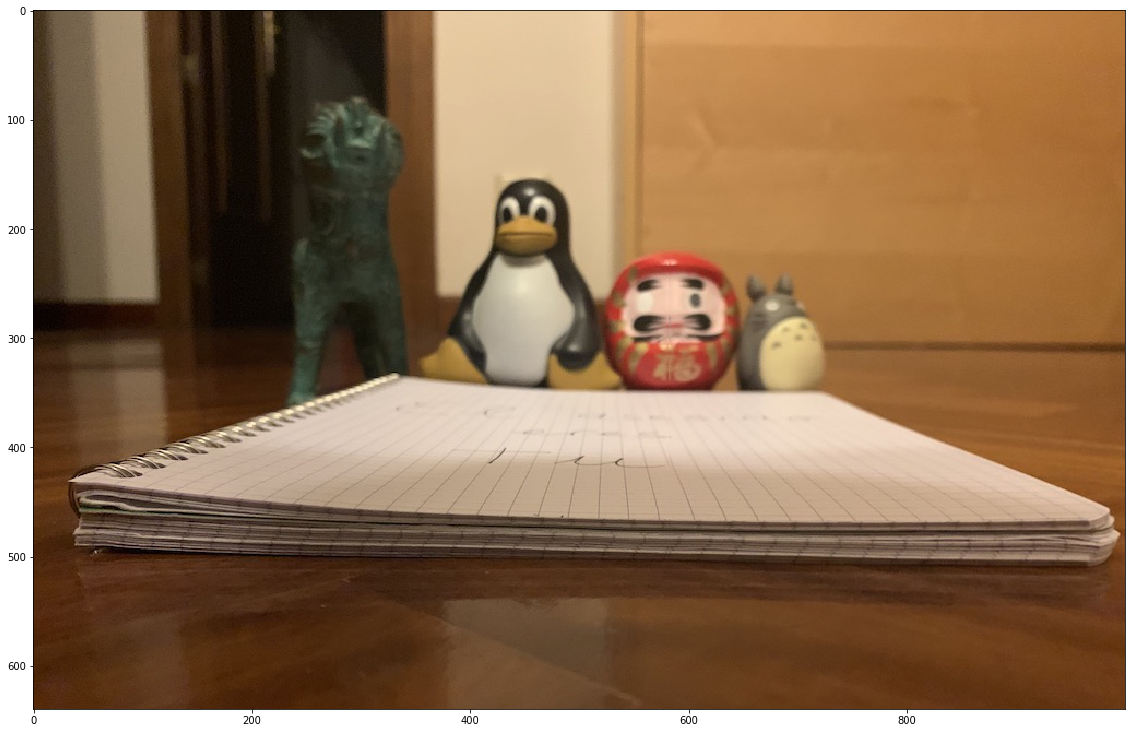

In [6]:
img_stitch = pega_imagenes(img_left_rgb, img_right_rgb, debug=False, transform=ProjectiveTransform)
dibujar_img(img_stitch, size=(16,16))

## Ortorrectificación

Una vez que tengas una sola imagen, ¿se te ocurre alguna manera para poder leer lo que pone en la imagen?

In [7]:
esquinas = np.array([[380, 440], [700, 440], [700, 350], [310, 350]])
esquinas_orto = np.array([[0, 1000], [2000, 1000], [2000, 0], [0, 0]])

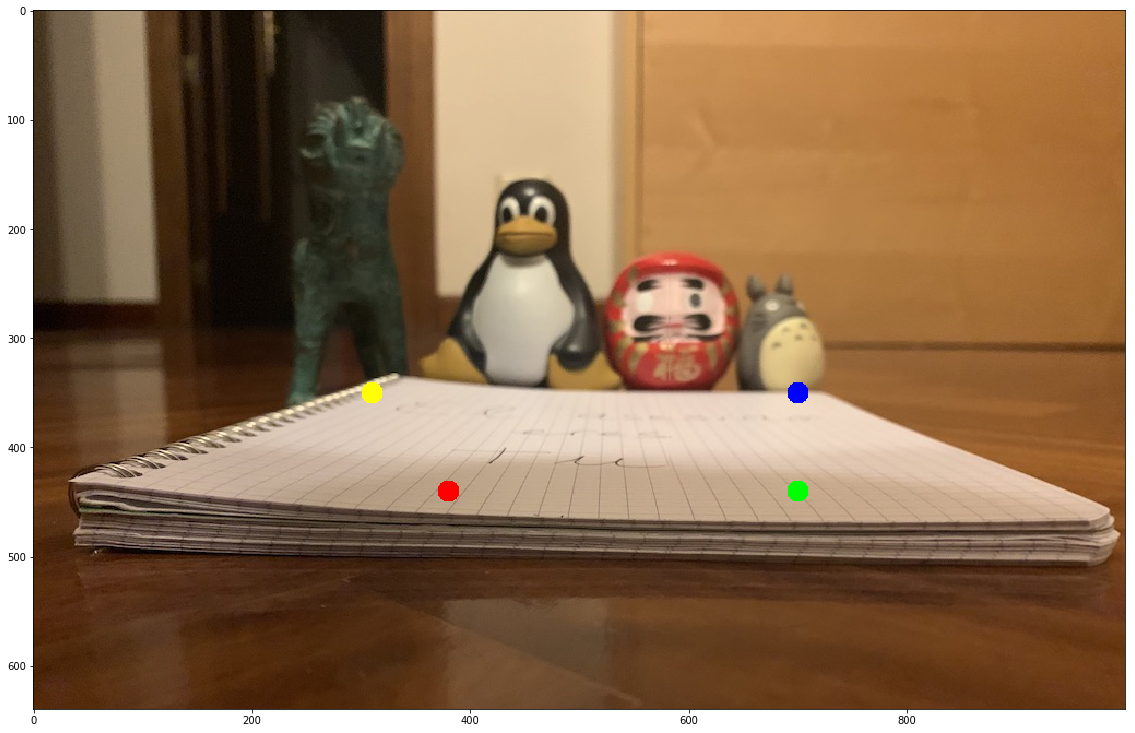

In [8]:
dibujar_img(dibujar_puntos(img_stitch, esquinas), size=(16,16))

In [9]:
proj = ProjectiveTransform()
proj.estimate(esquinas, esquinas_orto)
proj = proj + AffineTransform(translation=(300, 300))

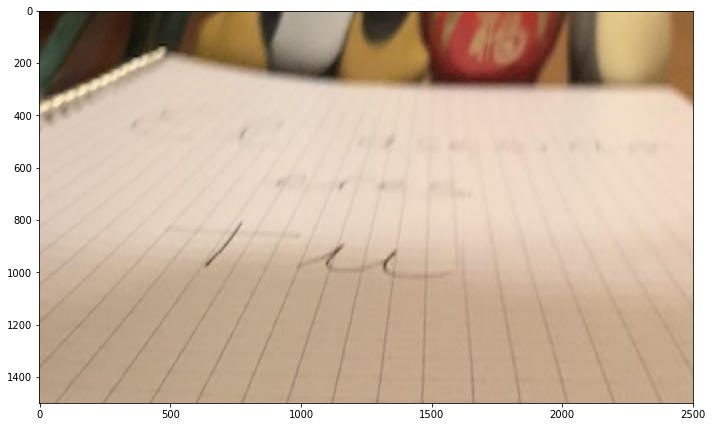

In [10]:
img_stitch_orto = warp(img_stitch, proj.inverse, output_shape=(1500, 2500))
dibujar_img(img_stitch_orto, size=(10,10))

## Mejora de imagen

¿Se te ocurre aplicar algún tipo de técnica que conozcamos para mejorar la imagen pegada?. Piensa que un juez tendrá que ver muy claras las pruebas.

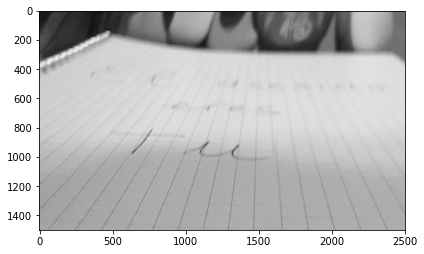

In [11]:

img_gris = color.rgb2gray(img_stitch_orto)
io.imshow(img_gris)
io.show()

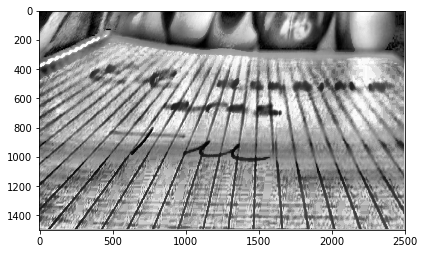

In [12]:
from skimage import exposure

img_equalized_adaptative = exposure.equalize_adapthist(img_gris, clip_limit=0.10)
io.imshow(img_equalized_adaptative)
io.show()

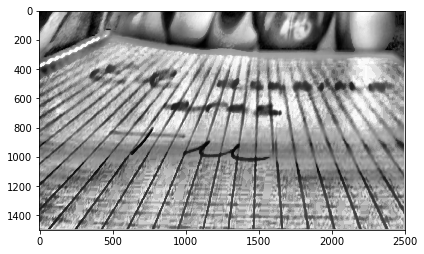

In [13]:
from skimage.filters import median
from skimage.morphology import disk


img_median = median(img_equalized_adaptative, disk(5))
io.imshow(img_median)
io.show()

## ¿Quién es el asesino?

"El asesino eres Tu"